## 1. Business Understanding

Tanzania faces serious water access challenges. Although many water points exist, a large portion are either non-functional or in need of repair. Timely identification of these wells can help allocate maintenance resources efficiently.

Objective:

The goal of this project is to predict the operational status of water points in rural Tanzania.
- Functional
- Functional but needs repair
- Non functional

This helps government and NGOs prioritize repairs and maintenance, improving access to clean water. Specifically, the findings will:
- Help NGOs prioritize maintenance.

- Support government agencies in planning new infrastructure.

- Optimize resource allocation for water access programs.

## 2. Data Understanding
 
 Dataset Overview:

The dataset contains information on water points across Tanzania.
It includes geographic, technical, and administrative attributes.

2.1 Target variable: status_group (binary label)

Key feature types:
2.2 Numerical: gps_height (elevation in meters), population, construction_year / well_age, amount_tsh (water amount)

2.3 Categorical: extraction_type_group, management_group, payment_type, quantity_group, source_type, water_quality, region, district_code, permit, public_meeting_flag

2.4 Datetime: date_recorded (used to derive year_recorded and month_recorded)

In [81]:
#import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#model libraries
import statsmodels.api as sm
from statsmodels.tools import add_constant
pd.set_option('display.max_columns', 50)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [82]:
# Loding the dataset
trg_set = pd.read_csv('training set values.csv')
test_set = pd.read_csv('test set values.csv')
trg_lbl = pd.read_csv('training set labels.csv')

# Check for missing values

In [83]:
# check for missing values in training set value
trg_set.isnull().sum()/len(trg_set)*100

id                        0.000000
amount_tsh                0.000000
date_recorded             0.000000
funder                    6.119529
gps_height                0.000000
installer                 6.153199
longitude                 0.000000
latitude                  0.000000
wpt_name                  0.000000
num_private               0.000000
basin                     0.000000
subvillage                0.624579
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.612795
recorded_by               0.000000
scheme_management         6.526936
scheme_name              47.417508
permit                    5.144781
construction_year         0.000000
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

In [84]:
# check for missing values in test set value
test_set.isnull().sum() / len(test_set)*100

id                        0.000000
amount_tsh                0.000000
date_recorded             0.000000
funder                    5.851852
gps_height                0.000000
installer                 5.905724
longitude                 0.000000
latitude                  0.000000
wpt_name                  0.000000
num_private               0.000000
basin                     0.000000
subvillage                0.666667
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.528620
recorded_by               0.000000
scheme_management         6.525253
scheme_name              47.757576
permit                    4.962963
construction_year         0.000000
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

Missing data present in some features e.g: gps_height, installer, subvillage, public_meeting, scheme_management, scheme_name permit and funder    

In [85]:
# check missing values in training label
trg_lbl.isnull().sum()

id              0
status_group    0
dtype: int64

In [86]:
# checking for duplicates in training set
trg_set.duplicated().sum()
test_set.duplicated().sum()
trg_lbl.duplicated().sum()

0

No duplicated columns

In [87]:
# Convert id to string in all dataframes
trg_set['id'] = trg_set['id'].astype(str).str.strip()
test_set['id'] = test_set['id'].astype(str).str.strip()
trg_lbl['id'] = trg_lbl['id'].astype(str).str.strip()

In [88]:
# merge Trg_set, test_set and trg_lbl
# Add a column to mark the source (train or test)
trg_set['source'] = 'train'
test_set['source'] = 'test'

# If test_set doesn't have target column, add a placeholder
test_set['status_group'] = 'status_group'   # replace 'status_group' with actual target name

# Concatenate vertically
full_data = pd.concat([trg_set, test_set], axis=0, ignore_index=True)

print(full_data.shape)
full_data.head()

(74250, 41)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,train,spring,groundwater,communal standpipe,communal standpipe,NaN
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,train,rainwater harvesting,surface,communal standpipe,communal standpipe,NaN
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,train,dam,surface,communal standpipe multiple,communal standpipe,NaN
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,train,borehole,groundwater,communal standpipe multiple,communal standpipe,NaN
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,train,rainwater harvesting,surface,communal standpipe,communal standpipe,NaN


In [89]:
#save the clean dataset
full_data.to_csv("tz_data_clean.csv", index=None)

In [90]:
full_data.dtypes

id                        object
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

## 3. Data Preparation

    3.1 Data Cleaning to handle missing values and outliers

In [91]:
# To handle Missing values
# drop scheme_name column since it has more than 45% missing values
missing_percentage = (full_data['scheme_name'].isnull().sum() / len(full_data)) * 100
print(f"Missing percentage for scheme_name: {missing_percentage:.2f}%")

if missing_percentage > 45:
    full_data.drop(columns=['scheme_name'], inplace=True)
    print("'scheme_name' column dropped ✅")
else:
    print("'scheme_name' retained ✅")

# Fill all NaN values in the dataset with 'N/A'

full_data = full_data.fillna('N/A')


Missing percentage for scheme_name: 47.49%
'scheme_name' column dropped ✅


In [92]:
full_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,train,spring,groundwater,communal standpipe,communal standpipe,N/A
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,N/A,GeoData Consultants Ltd,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,train,rainwater harvesting,surface,communal standpipe,communal standpipe,N/A
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,train,dam,surface,communal standpipe multiple,communal standpipe,N/A
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,train,borehole,groundwater,communal standpipe multiple,communal standpipe,N/A
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,N/A,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,train,rainwater harvesting,surface,communal standpipe,communal standpipe,N/A


In [93]:
full_data.isnull().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
w

Now the dataset is free from missing values and duplicates

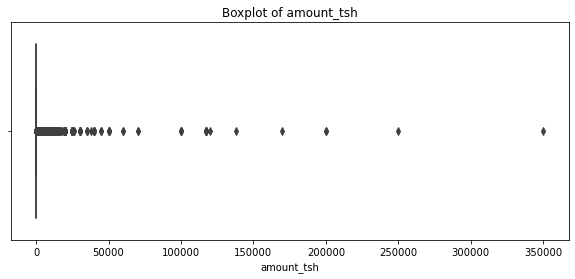

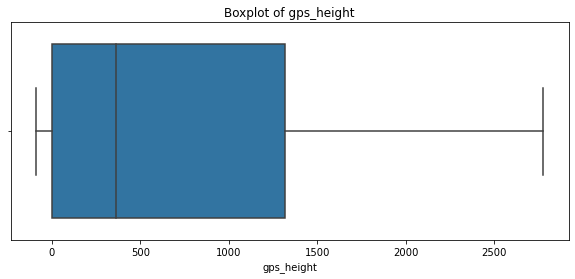

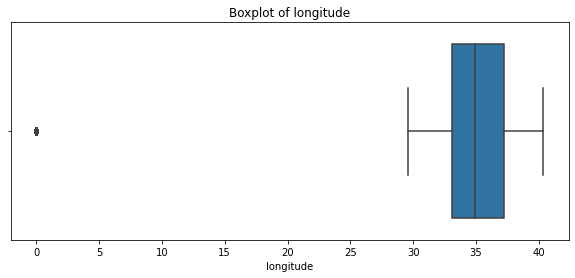

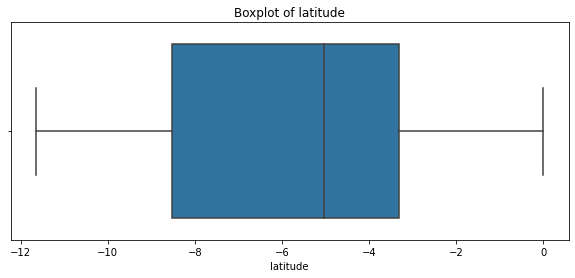

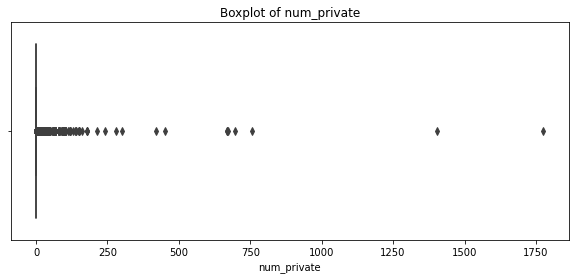

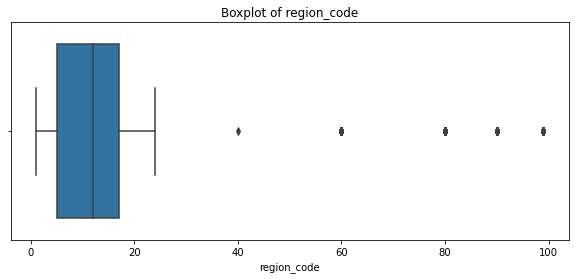

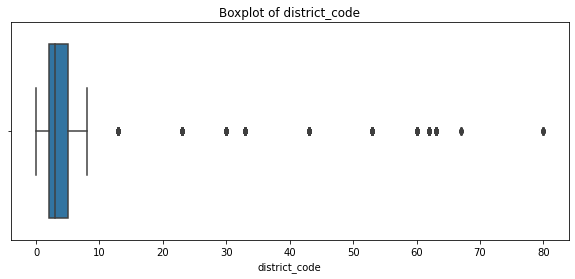

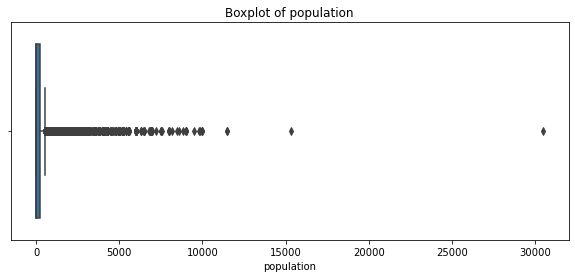

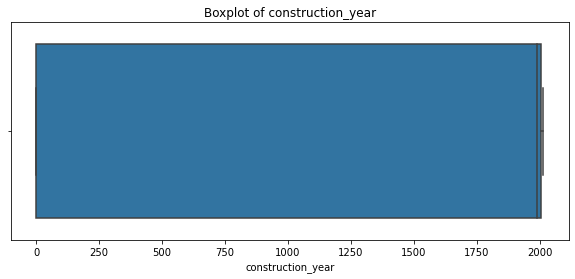

In [94]:
#check for outliers using boxplots
# Select only numerical columns
num_cols = full_data.select_dtypes(include=['int64', 'float64']).columns

# Loop and plot boxplot for each numeric column
for col in num_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=full_data[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()


The boxplots show presence of outliers in amount_tsh, gps_height, numPrivate, region_code, district code and population

3.2 Feature Engineering

In [95]:
# Select categorical/object columns
cat_cols = full_data.select_dtypes(include=['object']).columns
print(cat_cols)


Index(['id', 'date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')


In [96]:
full_data.nunique()

id                       74250
amount_tsh                 102
date_recorded              369
funder                    2141
gps_height                2456
installer                 2411
longitude                71870
latitude                 71869
wpt_name                 45684
num_private                 68
basin                        9
subvillage               21426
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2098
population                1128
public_meeting               3
recorded_by                  1
scheme_management           13
permit                       3
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity

In [97]:
# Group rare categories for high cardinality categorical variables
for col in cat_cols:
    top_labels = full_data[col].value_counts().nlargest(10).index
    full_data[col] = full_data[col].where(full_data[col].isin(top_labels), other='Other')
full_data[col]

0                 N/A
1                 N/A
2                 N/A
3                 N/A
4                 N/A
             ...     
74245    status_group
74246    status_group
74247    status_group
74248    status_group
74249    status_group
Name: status_group, Length: 74250, dtype: object

In [98]:
# Convert date_recorded to datetime
full_data['date_recorded'] = pd.to_datetime(full_data['date_recorded'], errors='coerce')

# Create a new feature: well age
full_data['well_age'] = full_data['date_recorded'].dt.year - full_data['construction_year']

# Replace negative ages or zeros with median
full_data['well_age'] = full_data['well_age'].apply(lambda x: x if x > 0 else full_data['well_age'].median())

# Binary feature: whether a public meeting was held
full_data['public_meeting_flag'] = full_data['public_meeting'].apply(lambda x: 1 if x == True else 0)

# Drop original boolean since it is not needed
full_data.drop(columns=['public_meeting'], inplace=True)

In [99]:
full_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,well_age,public_meeting_flag
0,Other,6000.0,2011-03-14,Other,1390,Other,34.938093,-9.856322,none,0,Lake Nyasa,Other,Iringa,11,5,Other,Other,109,GeoData Consultants Ltd,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,train,spring,groundwater,communal standpipe,communal standpipe,N/A,12.0,1
1,Other,0.0,NaT,Other,1399,Other,34.698766,-2.147466,Zahanati,0,Lake Victoria,Other,Other,20,2,Other,Other,280,GeoData Consultants Ltd,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,train,rainwater harvesting,surface,communal standpipe,communal standpipe,N/A,17.0,0
2,Other,25.0,NaT,Other,686,Other,37.460664,-3.821329,Other,0,Pangani,Majengo,Other,21,4,Other,Other,250,GeoData Consultants Ltd,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,train,dam,surface,communal standpipe multiple,communal standpipe,N/A,17.0,1
3,Other,0.0,NaT,Unicef,263,Other,38.486161,-11.155298,Other,0,Ruvuma / Southern Coast,Other,Other,90,63,Other,Other,58,GeoData Consultants Ltd,VWC,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,train,borehole,groundwater,communal standpipe multiple,communal standpipe,N/A,17.0,1
4,Other,0.0,NaT,Other,0,Other,31.130847,-1.825359,Shuleni,0,Lake Victoria,Other,Kagera,18,1,Other,Other,0,GeoData Consultants Ltd,N/A,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,train,rainwater harvesting,surface,communal standpipe,communal standpipe,N/A,17.0,1


In [100]:
# Convert date_recorded to datetime
full_data['date_recorded'] = pd.to_datetime(full_data['date_recorded'], errors='coerce')
# Create a new feature: well age
full_data['well_age'] = full_data['date_recorded'].dt.year - full_data['construction_year']
# Replace negative ages or zeros with median
full_data['well_age'] = full_data['well_age'].apply(lambda x: x if x > 0 else full_data['well_age'].median())

3.3   Important features to use in predicting this data
1. extraction_type_group - Certain pump types break down more often or last longer
2. management_group -Who manages the well affects maintenance quality
3. payment_type -Indicates if community pays for water → often linked to functionality
4. water_quality -Poor quality may indicate old or broken systems
5. quantity_group- Dry or insufficient quantity can be a sign of non-functional wells
6. source_type / source_class- The kind of water source (spring, river, borehole) affects reliability
7. construction_year / well_age- Older wells tend to be less functional
8. gps_height - Elevation can affect water pressure and pump success
9. population - High population may cause overuse and failure
10. region / district_code -Geographic patterns — some regions have higher failure rates
11. permit -Wells with proper permits often have more oversight
12. public_meeting_flag - May correlate with community involvement and maintenance

3.4 Feature engineering important features

In [101]:
# Categorical features to encode
categorical_cols = [
    'extraction_type_group',
    'management_group',
    'payment_type',
    'water_quality',
    'quantity_group',
    'source_type',
    'source_class'
]

# Numeric features to scale or keep
numeric_cols = [
    'construction_year',
    'well_age',
    'gps_height',
    'population',
    'region',
    'district_code',
    'public_meeting_flag'  # already numeric
]

# Binary categorical
binary_col = 'permit'


In [102]:
# Convert region to numeric if possible
full_data['region'] = pd.to_numeric(full_data['region'], errors='coerce')

full_data['region'] = full_data['region'].fillna(full_data['region'].median()) # region is supposed to be numeric
#a region code instead of names), hence it should be converted

C:\Users\maryl\OneDrive\Documents\ANACONDA\envs\learn-env\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [103]:
# Fill missing values in categorical columns
full_data[categorical_cols] = full_data[categorical_cols].fillna('N/A')

# Fill missing values in numeric columns
for col in numeric_cols:
    full_data[col] = full_data[col].fillna(full_data[col].median())

# Fill missing values in permit
full_data[binary_col] = full_data[binary_col].fillna('N/A')


In [104]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     74250 non-null  object        
 1   amount_tsh             74250 non-null  float64       
 2   date_recorded          6282 non-null   datetime64[ns]
 3   funder                 74250 non-null  object        
 4   gps_height             74250 non-null  int64         
 5   installer              74250 non-null  object        
 6   longitude              74250 non-null  float64       
 7   latitude               74250 non-null  float64       
 8   wpt_name               74250 non-null  object        
 9   num_private            74250 non-null  int64         
 10  basin                  74250 non-null  object        
 11  subvillage             74250 non-null  object        
 12  region                 0 non-null      float64       
 13  r

 3.5 Encode the permit Column (Yes/No). Convert the permit column to 0/1:

In [105]:
full_data['permit'] = full_data['permit'].map({'True': 1, 'False': 0, 'N/A': 0}).fillna(0).astype(int)

In [106]:
#Use Label Encoding for efficiency instead of one hot encoding
le = LabelEncoder()
for col in categorical_cols:
   full_data[col] = le.fit_transform(full_data[col].astype(str))
full_data[col]
#Now all categorical columns become integer-encoded.

0        0
1        1
2        1
3        0
4        1
        ..
74245    1
74246    0
74247    1
74248    1
74249    0
Name: source_class, Length: 74250, dtype: int32

3.6 Scale Numeric Features

In [107]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
full_data[numeric_cols] = scaler.fit_transform(full_data[numeric_cols])


C:\Users\maryl\OneDrive\Documents\ANACONDA\envs\learn-env\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\maryl\OneDrive\Documents\ANACONDA\envs\learn-env\lib\site-packages\sklearn\utils\extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [108]:
# check dtypes
print(full_data.dtypes)
print(full_data.head())

id                               object
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                      float64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                       int64
basin                            object
subvillage                       object
region                          float64
region_code                       int64
district_code                   float64
lga                              object
ward                             object
population                      float64
recorded_by                      object
scheme_management                object
permit                            int32
construction_year               float64
extraction_type                  object
extraction_type_group             int32
extraction_type_class            object


id — should be dropped before modeling. It’s an identifier, not a predictor. date_recorded — models can’t use datetime directly. We can: Extract year, month features Or drop it if not useful. All remaining object columns (categorical) need encoding:

Either Label Encoding (for tree-based models like Random Forest, XGBoost) Or One-Hot Encoding (for logistic regression, linear models)
status_group should be properly encoded as integers since it’s your target variable

In [109]:
#Drop or transform non-informative columns
full_data = full_data.drop(columns=['id', 'wpt_name', 'recorded_by'], errors='ignore')

#Encode status_group (target)
le = LabelEncoder()
full_data['status_group'] = le.fit_transform(full_data['status_group'].astype(str))

# Convert all categorical (object) columns to numeric
categorical_cols = full_data.select_dtypes(include='object').columns

for col in categorical_cols:
    full_data[col] = le.fit_transform(full_data[col].astype(str))
    
#Convert datetime
if 'date_recorded' in full_data.columns:
    full_data['year_recorded'] = full_data['date_recorded'].dt.year
    full_data['month_recorded'] = full_data['date_recorded'].dt.month
    full_data = full_data.drop(columns=['date_recorded'])
else:
    print("⚠️ 'date_recorded' column not found — skipping date feature extraction.")


print(full_data.dtypes)


amount_tsh               float64
funder                     int32
gps_height               float64
installer                  int32
longitude                float64
latitude                 float64
num_private                int64
basin                      int32
subvillage                 int32
region                   float64
region_code                int64
district_code            float64
lga                        int32
ward                       int32
population               float64
scheme_management          int32
permit                     int32
construction_year        float64
extraction_type            int32
extraction_type_group      int32
extraction_type_class      int32
management                 int32
management_group           int32
payment                    int32
payment_type               int32
water_quality              int32
quality_group              int32
quantity                   int32
quantity_group             int32
source                     int32
source_typ

Now the datasets are either float64, int32 or int64. prefect for modeling

In [110]:
full_data

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,well_age,public_meeting_flag,year_recorded,month_recorded
0,6000.0,5,1.045581,8,34.938093,-9.856322,0,1,8,NaN,11,-0.065246,9,9,-0.152310,5,0,0.735593,2,2,0,6,4,2,0,6,2,1,1,1,6,0,1,1,0,-0.141725,0.405862,2011.0,3.0
1,0.0,5,1.058572,8,34.698766,-2.147466,0,4,8,NaN,20,-0.376399,9,9,0.210683,2,0,0.747143,2,2,0,10,4,0,2,6,2,2,2,1,3,1,1,1,0,-0.120741,-2.463890,NaN,NaN
2,25.0,5,0.029350,8,37.460664,-3.821329,0,5,3,NaN,21,-0.168964,9,9,0.147000,5,0,0.746093,2,2,0,6,4,4,5,6,2,1,1,1,1,1,2,1,0,-0.120741,0.405862,NaN,NaN
3,0.0,8,-0.581254,8,38.486161,-11.155298,0,7,8,NaN,90,5.950371,9,9,-0.260572,5,0,0.721942,9,9,5,6,4,0,2,6,2,0,0,1,0,0,2,1,0,-0.120741,0.405862,NaN,NaN
4,0.0,5,-0.960897,8,31.130847,-1.825359,0,4,8,NaN,18,-0.480117,9,9,-0.383692,1,0,-1.363441,2,2,0,2,1,0,2,6,2,3,3,1,3,1,1,1,0,-0.120741,0.405862,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,0.0,0,-0.911817,8,38.852669,-6.582841,0,8,8,NaN,6,-0.480117,1,9,-0.341237,5,0,0.724042,5,4,2,6,4,0,2,6,2,1,1,0,4,1,1,1,1,-0.120741,0.405862,NaN,NaN
74246,1000.0,5,-0.960897,8,37.451633,-5.350428,0,5,8,NaN,4,0.142189,9,9,5.899702,5,0,0.730342,6,5,1,6,4,2,0,4,4,2,2,0,5,0,4,3,1,-0.120741,0.405862,NaN,NaN
74247,0.0,4,1.169722,7,34.739804,-4.585587,0,0,8,NaN,13,-0.376399,9,9,0.040862,5,0,0.747143,2,2,0,6,4,0,2,6,2,2,2,0,1,1,1,1,1,-0.120741,0.405862,NaN,NaN
74248,0.0,5,0.479725,3,35.432732,-10.584159,0,1,8,NaN,10,-0.376399,9,9,-0.065277,5,0,0.746093,2,2,0,6,4,0,2,6,2,2,2,0,4,1,1,1,1,-0.120741,0.405862,NaN,NaN


3.7 Selecting Features for Modeling

In [111]:
#divide data into label and features
y = full_data.status_group
X = full_dataX = full_data[[
    'extraction_type_group',
    'management_group',
    'payment_type',
    'water_quality',
    'quantity_group',
    'source_type',
    'source_class',
    'construction_year',
    'well_age',
    'gps_height',
    'population',
    'district_code',
    'public_meeting_flag'
]]
print(X)
print(y)

       extraction_type_group  management_group  payment_type  water_quality  \
0                          2                 4             0              6   
1                          2                 4             2              6   
2                          2                 4             5              6   
3                          9                 4             2              6   
4                          2                 1             2              6   
...                      ...               ...           ...            ...   
74245                      4                 4             2              6   
74246                      5                 4             0              4   
74247                      2                 4             2              6   
74248                      2                 4             2              6   
74249                      2                 4             2              6   

       quantity_group  source_type  source_class  c

In [112]:
X.columns

Index(['extraction_type_group', 'management_group', 'payment_type',
       'water_quality', 'quantity_group', 'source_type', 'source_class',
       'construction_year', 'well_age', 'gps_height', 'population',
       'district_code', 'public_meeting_flag'],
      dtype='object')

extraction_type_group    0.007213
population               0.003570
well_age                 0.003377
quantity_group           0.000050
district_code           -0.000139
source_type             -0.000476
public_meeting_flag     -0.001140
water_quality           -0.001887
source_class            -0.002732
payment_type            -0.002924
construction_year       -0.004597
management_group        -0.007204
gps_height              -0.007593
dtype: float64


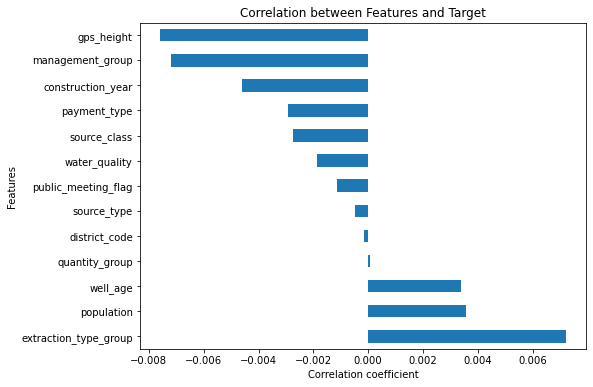

In [113]:
# Correlation between features and target
corr_with_target = X.corrwith(y)
corr_with_target = corr_with_target.sort_values(ascending=False)

# Print top correlations
print(corr_with_target)

# Plot
plt.figure(figsize=(8,6))
corr_with_target.plot(kind='barh')
plt.title('Correlation between Features and Target')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()


The correlation between the features and the target are too small

In [114]:
# Compute correlation matrix
corr_matrix = X.corr()

# Display the matrix
print(corr_matrix)

                       extraction_type_group  management_group  payment_type  \
extraction_type_group               1.000000         -0.069416      0.136371   
management_group                   -0.069416          1.000000     -0.088475   
payment_type                        0.136371         -0.088475      1.000000   
water_quality                      -0.108116          0.000201     -0.048939   
quantity_group                     -0.008013         -0.061587      0.005411   
source_type                        -0.337358          0.114377     -0.172721   
source_class                       -0.168234         -0.102376     -0.037874   
construction_year                  -0.042906         -0.076484     -0.019744   
well_age                            0.028299          0.020538      0.011954   
gps_height                         -0.248830          0.026319     -0.099745   
population                          0.057458         -0.026514      0.032895   
district_code                       0.01

There is weak correlation between the features themselves the highest being 0.337 i.e between the source type and extraction_type_group 

extraction_type_group -  object
management_group -  object
payment_type -  object
water_quality-  object
quantity_group - object
source_type / source_class -object
construction_year / well_age - integer
gps_height - integer
population - integer
region / district_code - integer
permit - object
public_meeting_flag - integer

##  4. Modeling

In [115]:
# perform Train-test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [116]:
#Normalization using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# first model

In [117]:
# build Baseline Model — Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=2000, multi_class='multinomial')
logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     11880
           1       0.00      0.00      0.00      2970

    accuracy                           0.80     14850
   macro avg       0.40      0.50      0.44     14850
weighted avg       0.64      0.80      0.71     14850



C:\Users\maryl\OneDrive\Documents\ANACONDA\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Accuracy = 0.80 (80%)
This means the model correctly predicted 80% of the test samples overall. The model is predicting everything as class 0, leading to high accuracy but very poor recall and precision for other classes
Accuracy looks “good” at 80%, but it’s misleading.

The model completely ignores the minority class (class 1).
This makes it unreliable for real-world use, especially for detecting failed wells. This is a clear justification for the othe model.
Logistic Regression, by default, optimizes overall accuracy and is biased toward the majority class. High recall for class 0 and zero recall for class 1 means the model is practically useless for maintenance planning.

In [118]:
#check the metrics
#  Make predictions
y_pred = logreg.predict(X_test)    # or rf_clf.predict(X_test), tree_clf, etc.

# 2. Then compute metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MAE: 0.20
MSE: 0.20
RMSE: 0.45
R² Score: -0.25


#Interpretation
MAE/RMSE are small but not meaningful here because the target is categorical.
Negative R² confirms that regression metrics are not appropriate for this classification task.

The reason to switch to classification metrics to correctly assess model’s performance.

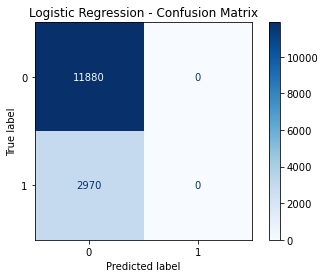

In [119]:
# Evaluate the baseline model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate predictions
y_pred = log_reg.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


#interprtation
True Positives (TP) = 0 → actual 1 predicted as 1
True Negatives (TN) = 11880 → actual 0 predicted as 0
False Positives (FP) = 0 → actual 0 predicted as 1
False Negatives (FN) = 2970 → actual 1 predicted as 0

the model correctly predicted all class 0 samples (11880 out of 11880).
The model did not predict any class 1 samples correctly — it classified all 2970 actual class 1 instances as class 0.

# Second :use model with balanced Class Weights 

              precision    recall  f1-score   support

           0       0.80      0.55      0.65     11880
           1       0.19      0.43      0.27      2970

    accuracy                           0.53     14850
   macro avg       0.50      0.49      0.46     14850
weighted avg       0.68      0.53      0.58     14850



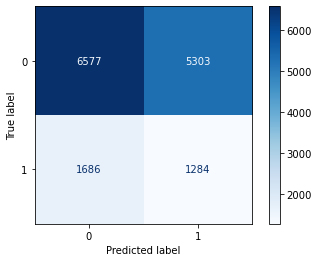

In [120]:
# Handle Class Imbalance
#Use class_weight='balanced' in Logistic Regression to give more importance to the minority class

log_reg_bal = LogisticRegression(
    max_iter=2000,
    multi_class='multinomial',
    class_weight='balanced'
)
log_reg_bal.fit(X_train, y_train)
y_pred_bal = log_reg_bal.predict(X_test)

print(classification_report(y_test, y_pred_bal))
cm = confusion_matrix(y_test, y_pred_bal)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')


# Interpretation of Metrics
Class 0 (Majority class — “Functional” wells)

Precision 0.80: 80% of wells predicted as class 0 were correct.

Recall 0.55: The model correctly identified 55% of actual class 0 wells (missed 45%).

F1-score 0.65: Reasonable balance between precision and recall.

Class 1 (Minority class — “Non-functional/needs repair” wells)

Precision 0.19: Only 19% of wells predicted as class 1 were actually class 1.

Recall 0.43: The model correctly identified 43% of actual class 1 wells (this is a big improvement from 0% earlier).

F1-score 0.27: Still low, but at least the model is now catching some failing wells.

Compared to your previous model, recall for class 1 has increased from 0.00 → 0.43

True Negatives (TN) = 6577
→ Correctly predicted class 0.

False Positives (FP) = 5303
→ Actual class 0 predicted as class 1.

False Negatives (FN) = 1686
→ Actual class 1 predicted as class 0.

True Positives (TP) = 1284
→ Correctly predicted class 1.


Interpretation:
The model no longer predicts everything as class 0.
It successfully identified 1,284 failing wells (class 1).
It also made many mistakes predicting some functional wells as failing (5303 FP) — which lowered overall accuracy.
But in real-world NGO or government water management, catching failed wells is usually more important than getting perfect accuracy.

Why Accuracy Dropped but Model Improved?
Accuracy fell from 80% ➝ 53% because the model now predicts both classes, not just the dominant one.
This is expected — accuracy alone can be misleading when classes are imbalanced.
Recall for minority class improved significantly, which means better coverage of problem wells.
In practical applications (e.g., finding non-functional pumps), improving recall for class 1 is often more valuable than maximizing accuracy.

Next Steps to Improve Further
Use more powerful models i.e A tree-based model like RandomForestClassifier

# Third Model -RandomForestClassifier

In [121]:
#Step 1: Import and Initialize the Model
from sklearn.ensemble import RandomForestClassifier

# Initialize the model with some sensible defaults
rf_clf = RandomForestClassifier(
    n_estimators=200,           # number of trees
    max_depth=None,            # let trees expand fully
    random_state=42,           # reproducibility
    n_jobs=-1,                 # use all CPU cores
    class_weight='balanced'    # handle class imbalance
)

In [122]:
#Step 2: Train the Model

rf_clf.fit(X_train, y_train) #The model will build an ensemble of decision trees, each trained on a bootstrap sample of your data.

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [123]:
#Step 3: Make Predictions

y_pred_rf = rf_clf.predict(X_test)

Random Forest Accuracy: 0.6977104377104377
              precision    recall  f1-score   support

           0       0.80      0.83      0.81     11880
           1       0.20      0.17      0.18      2970

    accuracy                           0.70     14850
   macro avg       0.50      0.50      0.50     14850
weighted avg       0.68      0.70      0.69     14850



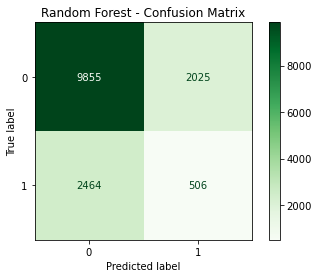

In [124]:
#Step 4: Evaluate the Model

# Classification metrics
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title("Random Forest - Confusion Matrix")
plt.show()


Accuracy: 0.70 (69.8%)
Macro avg: precision 0.50, recall 0.50, F1-score 0.50
Weighted avg: precision 0.68, recall 0.70, F1-score 0.69

Class-Level Interpretation
Class 0 (Majority Class — Functional wells)
Precision 0.80: 80% of wells predicted as functional are actually functional.
Recall 0.83: Model correctly identified 83% of all functional wells.
F1-score 0.81: Very strong performance for the majority class.
This is good — the model is reliable for identifying wells that work.

Class 0 (Majority Class — Functional wells)
Precision 0.80: 80% of wells predicted as functional are actually functional.
Recall 0.83: Model correctly identified 83% of all functional wells.
F1-score 0.81: Very strong performance for the majority class.
This is good — the model is reliable for identifying wells that work.

Class 1 (Minority Class — Non-functional/needs repair)
Precision 0.20: Only 20% of wells predicted as non-functional were correct.
Recall 0.17: Model only detected 17% of actual failing wells which is too low
F1-score 0.18: Performance for this class remains weak.
This shows the model still struggles with the minority class, even though it improved compared to the first logistic regression model (which had 0% recall at first)

Confusion Matrix
True Negatives (TN) = 9855 → Correctly predicted functional wells 
False Positives (FP) = 2025 → Functional wells incorrectly predicted as non-functional 
False Negatives (FN) = 2464 → Non-functional wells missed 
True Positives (TP) = 506 → Non-functional wells correctly identified

Model Behavior Summary
The model accurately predicts most functional wells.
It detects some failing wells (506), which is better than the baseline logistic regression that detected none initially.
However, the recall for failing wells (17%) is still too low if the real-world goal is to find and repair broken pumps.
Many failing wells (2464) were misclassified as functional, which would be costly in practice (missed repairs).

Why Class 1 Performance Is Low
Class imbalance: There are far fewer failing wells (2,970 vs. 11,880), so the model is biased toward predicting class 0.
Default Random Forest settings: By default, RF optimizes overall accuracy, not minority recall.
Feature importance and data quality: Some features may not be strong enough to distinguish failing vs functional wells.

Recommendations to Improve Model Performance
1. Class imbalance handling
we can try oversampling techniques like SMOTE

# fourth model

In [125]:
# Initialize SMOTE
sm = SMOTE(random_state=42)

# Apply SMOTE to balance the training set
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(y_train_resampled.value_counts())

Before SMOTE:
0    47520
1    11880
Name: status_group, dtype: int64

After SMOTE:
1    47520
0    47520
Name: status_group, dtype: int64


SMOTE has oversampled class 1 to match the count of class 0.
Both classes now have 47,520 samples each → perfectly balanced training data.
This means the model will:

Have more opportunities to learn patterns for failing wells (class 1),
Be less biased toward always predicting class 0,
Likely improve recall and F1-score for class 1 on the test set.

In [126]:
#Train RandomForestClassifier on X_train_resampled and y_train_resampled
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

Random Forest (with SMOTE) Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.80      0.76      0.78     11880
           1       0.21      0.25      0.23      2970

    accuracy                           0.66     14850
   macro avg       0.50      0.51      0.50     14850
weighted avg       0.68      0.66      0.67     14850



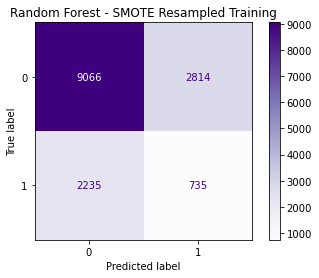

In [127]:
#to evaluate on X_test to see if class 1 recall improved
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_rf_smote = rf_clf.predict(X_test)

print("Random Forest (with SMOTE) Accuracy:", accuracy_score(y_test, y_pred_rf_smote))
print(classification_report(y_test, y_pred_rf_smote))

cm = confusion_matrix(y_test, y_pred_rf_smote)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Purples')
plt.title("Random Forest - SMOTE Resampled Training")
plt.show()


# model results after using SMOTE
735 true positives (non-functional wells correctly detected).

2235 false negatives (still missed some, but fewer than before SMOTE)
Before SMOTE, almost all of class 1 was missed.
This is a clear improvement

Interpretation:
SMOTE successfully improved minority class recall without major loss in accuracy.
Precision for class 1 remains low — this is expected since we’re predicting more positives.
Model is now better at identifying failing wells, which is often the priority in public health and infrastructure use cases.

In [128]:
#Train models with different parameter sets.
#Use cross_val_score() to compare performance
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5, scoring='recall')
print("Recall (mean):", scores.mean())

Recall (mean): 0.7033670033670034


In [129]:
# Define and train the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Define Random Forest model
rf_clf_smote = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Fit on SMOTE-resampled training data
rf_clf_smote.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [130]:
# Make prediction

# Predictions on training and test data
y_train_pred = rf_clf_smote.predict(X_train_resampled)
y_test_pred = rf_clf_smote.predict(X_test)

In [131]:
# Evaluate model performance

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

print("=== Training Metrics ===")
print("Accuracy:", accuracy_score(y_train_resampled, y_train_pred))
print("Recall:", recall_score(y_train_resampled, y_train_pred))
print("F1:", f1_score(y_train_resampled, y_train_pred))

print("\n=== Test Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

print("\n=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_test_pred))


=== Training Metrics ===
Accuracy: 0.8873526936026936
Recall: 0.8899410774410774
F1: 0.8876435153117981

=== Test Metrics ===
Accuracy: 0.66
Recall: 0.2474747474747475
F1: 0.22549470777726646

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

           0       0.80      0.76      0.78     11880
           1       0.21      0.25      0.23      2970

    accuracy                           0.66     14850
   macro avg       0.50      0.51      0.50     14850
weighted avg       0.68      0.66      0.67     14850



# Interpretation
Accuracy is 0.66, a moderate score — but as we’ve established, accuracy isn’t the main goal here.
Recall for class 1 (failing wells) is 0.247, meaning 24.7% of failing wells in the test set were correctly identified
F1 is 0.225, which shows some balance between precision and recall — but it’s much lower than the training set.

The gap between training and testing performance suggests the model is learning patterns too specifically from the training data — classic overfitting

SMOTE helped boost recall for failing wells to ~25%.
Model overfits the training data, as shown by the big metric drop on test data.
Precision is low, but this is acceptable if catching failing wells is a priority.

# Recommendation
hyperparameter tuning or threshold adjustment to improve generalization.

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Base model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [133]:
# Define parameter distributions
param_dist = {
    'n_estimators': randint(100, 400),         # number of trees
    'max_depth': [None, 10, 20, 30, 40],       # depth of each tree
    'min_samples_split': [2, 5, 10],           # min samples to split node
    'min_samples_leaf': [1, 2, 4],             # min samples in leaf node
    'max_features': ['sqrt', 'log2'],          # number of features for split
    'class_weight': [None, 'balanced']         # to address imbalance
}

In [134]:
# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,                   # number of random combinations
    cv=3,
    scoring='recall',           # optimize for recall (minority class)
    n_jobs=-1,
    random_state=42,
    verbose=2
)

In [ ]:
# Fit search on SMOTE-resampled data
random_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_rf = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min


# Evaluate Tuned Model 

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score

y_test_pred_tuned = best_rf.predict(X_test)

print("=== Tuned Model Test Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred_tuned))
print("Recall:", recall_score(y_test, y_test_pred_tuned))
print("F1:", f1_score(y_test, y_test_pred_tuned))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred_tuned))


In [48]:
#Step 1 — Hyperparameter Tuning
#After confirming SMOTE improves recall, you can fine-tune further:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define base model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Manual Tuning with Cross-Validation Scores

In [49]:
#Train models with different parameter sets.
#Use cross_val_score() to compare performance
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5, scoring='recall')
print("Recall (mean):", scores.mean())


Recall (mean): 0.7033670033670034


## 5. Evaluation

## 6. Deployment